In [71]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [72]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

In [73]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

In [74]:
# Drafted を目的変数として切り離し
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

# School, Player_Type, Position_Type は使用しない場合は最初からdrop
X = X.drop(columns=["School", "Player_Type", "Position_Type"])
test = test.drop(columns=["School", "Player_Type", "Position_Type"])

# Position は Target Encoding + Group Encoding にのみ使用
# Label Encodingは不要

In [75]:
# PositionをTarget Encoding（全体平均ベース、これは許容範囲）
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# Position_groupを作成（これは合法・安全）
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

# fold-safeな target encoding を実施
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0  # 初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)

# testデータには全体平均から算出（合法）
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

# 不要な文字列列は削除（エラー防止）
X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\3887577351.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 

In [76]:
from sklearn.preprocessing import MinMaxScaler

# kg → lbs
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

# Speed Score
X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)

# Burst Score
X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]

# Agility Score
X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

# ASI（Athletic Score Index）
X["ASI"] = (
    0.5 * X["SpeedScore"] +
    0.3 * X["BurstScore"] +
    0.2 * X["AgilityScore"]
)
test["ASI"] = (
    0.5 * test["SpeedScore"] +
    0.3 * test["BurstScore"] +
    0.2 * test["AgilityScore"]
)

# RSA スケーリング特徴量作成
rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]

for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])


In [77]:
# 学習に使いたい全特徴量を明示的にリストアップ
all_features = [
    'Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
    'Broad_Jump', 'Agility_3cone', 'Shuttle',
    'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing',
    'ASI',  # ✅ 使用
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'  # ✅ 使用
]

# 重複削除
all_features = list(dict.fromkeys(all_features))

print(all_features)

['Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle', 'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing', 'ASI', 'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone']


In [78]:
all_features = [
    'Year', 'Height', 'Weight', 'Broad_Jump',
    'Position_encoded', 'Position_group_encoded',
    'Age_filled', 'Age_missing',
    'ASI',  # RSAに基づく重要指標
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'
]

In [79]:
X["BMI"] = X["Weight"] / (X["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

all_features += ["BMI"]
all_features = list(dict.fromkeys(all_features))

# all_features から Weight, Height を削除
all_features = [col for col in all_features if col not in ["Weight", "Height"]]

all_features = [col for col in all_features if col != "Age_missing"]


all_features = [f for f in all_features if f != "BMI"]

if "Weight" not in all_features:
    all_features.append("Weight")
if "Height" not in all_features:
    all_features.append("Height")

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

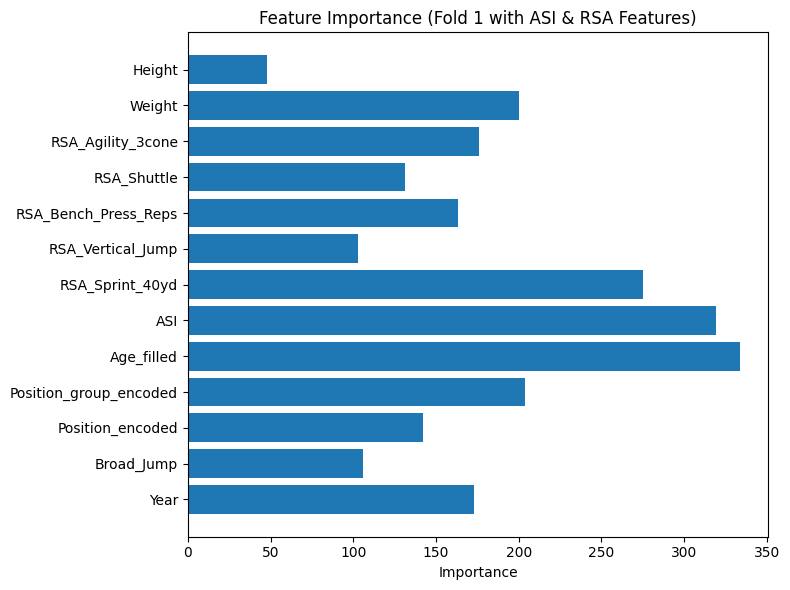

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [80]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

X_feat = X[all_features]
y_feat = y

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_feat)):
    X_train, X_valid = X_feat.iloc[train_idx], X_feat.iloc[valid_idx]
    y_train, y_valid = y_feat.iloc[train_idx], y_feat.iloc[valid_idx]
    
    model = LGBMClassifier(
        max_depth=4,
        num_leaves=10,
        min_child_samples=50,
        reg_alpha=5.0,
        reg_lambda=5.0,
        learning_rate=0.03,
        n_estimators=700,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_feat.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [81]:
# 🚩 School 列を復元する（削除済の場合）
if "School" not in X.columns:
    df_raw = pd.read_csv("../data/train.csv")
    X["School"] = df_raw["School"]

if "School" not in test.columns:
    test_raw = pd.read_csv("../data/test.csv")
    test["School"] = test_raw["School"]

print("✅ School 列を復元完了")


✅ School 列を復元完了


In [82]:
# =====================================================
# 🎯 School 特徴量エンジニアリング（合法ドメイン知識活用）
# =====================================================

import pandas as pd
from sklearn.model_selection import KFold

# 1️⃣ Drafted 数・率を school ごとに集計
school_stats = X.copy()
school_stats["Drafted"] = y
school_agg = school_stats.groupby("School")["Drafted"].agg(["sum", "count"])
school_agg["Drafted_Rate"] = school_agg["sum"] / school_agg["count"]

# School_Drafted_Count (スカウト注目度の proxy)
school_drafted_count = school_agg["sum"]

# School_Drafted_Rate
school_drafted_rate = school_agg["Drafted_Rate"]

# 2️⃣ 常連校フラグ作成（Drafted 数上位 20 校を常連校とする例）
top_n = 20
top_schools = school_drafted_count.sort_values(ascending=False).head(top_n).index.tolist()

X["School_Top"] = X["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

# 3️⃣ School_Drafted_Count をマッピング
X["School_Drafted_Count"] = X["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School_Drafted_Count"].fillna(0)  # 未知校は 0 扱い

# 4️⃣ fold-safe Target Encoding (School_Drafted_Rate)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["School_Drafted_Rate_TE"] = 0.0  # floatで初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    rate_map = X_train.assign(Drafted=y_train).groupby("School")["Drafted"].mean()
    X.loc[val_idx, "School_Drafted_Rate_TE"] = X.loc[val_idx, "School"].map(rate_map)

# test には全体の rate_map で付与
final_rate_map = X.assign(Drafted=y).groupby("School")["Drafted"].mean()
test["School_Drafted_Rate_TE"] = test["School"].map(final_rate_map)
test["School_Drafted_Rate_TE"] = test["School_Drafted_Rate_TE"].fillna(y.mean())  # 未知校は平均で補完

# 5️⃣ 不要な元の School 列は削除
X = X.drop(columns=["School"])
test = test.drop(columns=["School"])

# 6️⃣ 追加特徴量リストに加える場合
new_school_features = ["School_Top", "School_Drafted_Count", "School_Drafted_Rate_TE"]
for col in new_school_features:
    if col not in all_features:
        all_features.append(col)

print(f"✅ School 特徴量エンジニアリング完了: {new_school_features}")


✅ School 特徴量エンジニアリング完了: ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']


In [83]:
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))  # 重複排除

In [84]:
# 特徴量追加
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))

# 学習・スコア確認へ進む

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

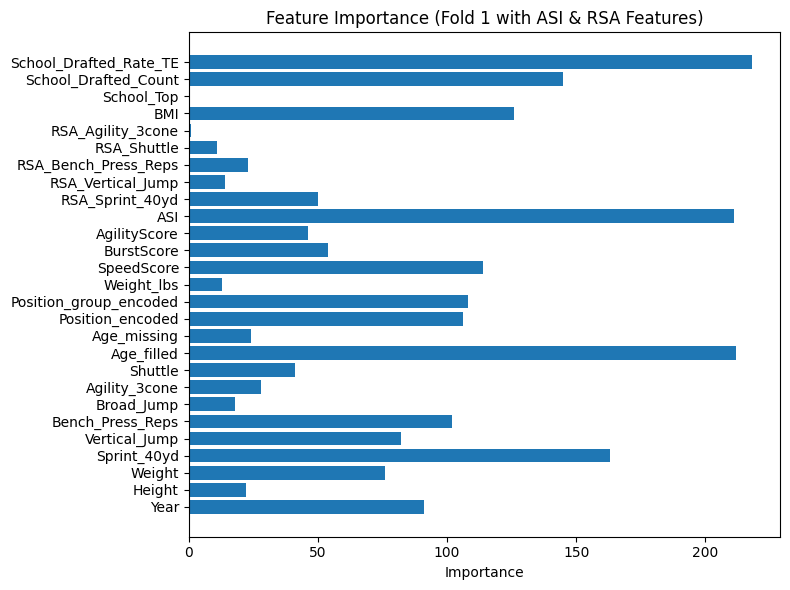

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [85]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# ✅ 08モデルパラメータ固定
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns  # ✅ 対応する特徴量名
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[166]	valid_0's auc: 0.862216	valid_0's binary_logloss: 0.409837
✅ Fold 1 - Train AUC: 0.8916, Validation AUC: 0.8622


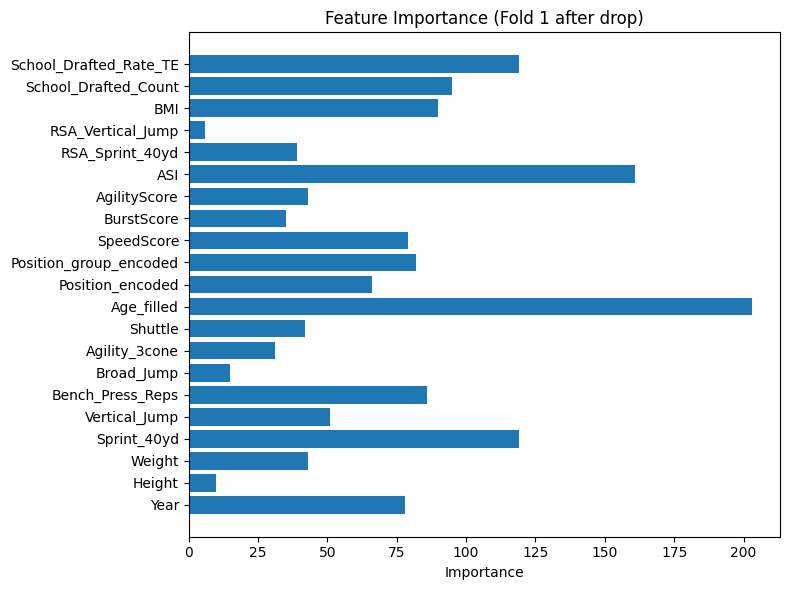

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[119]	valid_0's auc: 0.844622	valid_0's binary_logloss: 0.430819
✅ Fold 2 - Train AUC: 0.8919, Validation AUC: 0.8446
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the ove

In [86]:
# 不要カラムを削除
drop_cols = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
]

X_reduced = X.drop(columns=[col for col in drop_cols if col in X.columns])

# 再度モデルを定義
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced)):
    X_train, X_valid = X_reduced.iloc[train_idx], X_reduced.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

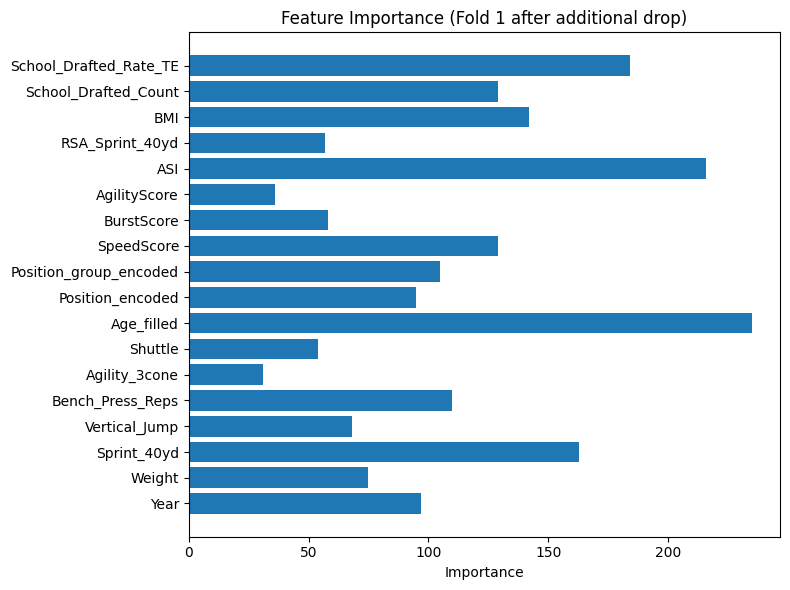

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [87]:
# 追加削除するカラム
drop_cols_additional = ["RSA_Vertical_Jump", "Broad_Jump", "Height"]

# すでに削除したカラムと合わせて削除
drop_cols_total = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
] + drop_cols_additional

# カラム削除
X_reduced2 = X.drop(columns=[col for col in drop_cols_total if col in X.columns])

# モデル定義（パラメータはそのまま）
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after additional drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


### "Agility_3cone"を削除
AUC差緩和

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.86369	valid_0's binary_logloss: 0.408355
✅ Fold 1 - Train AUC: 0.8928, Validation AUC: 0.8637


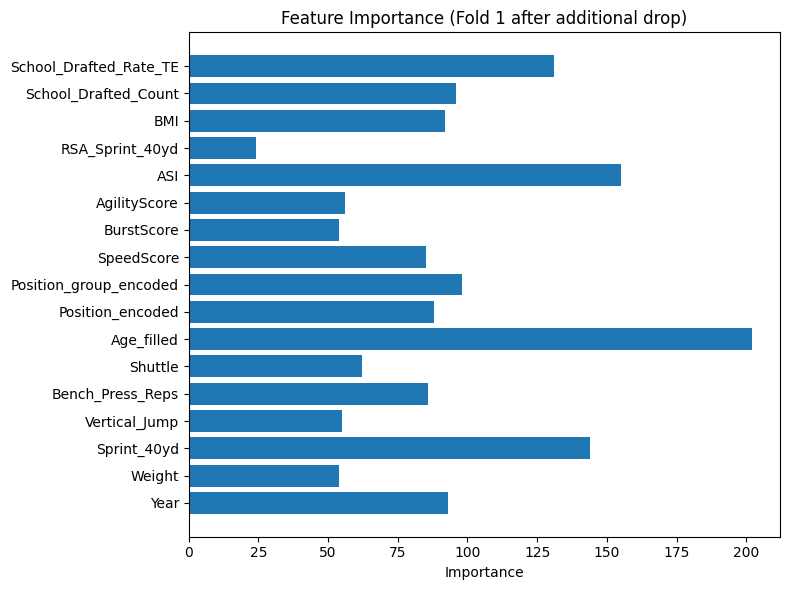

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.843921	valid_0's binary_logloss: 0.433256
✅ Fold 2 - Train AUC: 0.8886, Validation AUC: 0.8439
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data p

In [88]:
# 追加削除するカラム
drop_cols_additional = ["RSA_Vertical_Jump", "Broad_Jump", "Height","Agility_3cone"]

# すでに削除したカラムと合わせて削除
drop_cols_total = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
] + drop_cols_additional

# カラム削除
X_reduced2 = X.drop(columns=[col for col in drop_cols_total if col in X.columns])

# モデル定義（パラメータはそのまま）
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after additional drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [89]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np

# Optuna objective
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 7, 31),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 1000,
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, valid_idx in kf.split(X_reduced2, y):
        X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(0)
            ]
        )
        
        y_valid_pred = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_valid_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# 実行
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("✅ Best AUC:", study.best_value)
print("✅ Best Params:", study.best_params)

[I 2025-06-28 18:06:33,335] A new study created in memory with name: no-name-e02bb8b8-4558-43a3-954b-b80fe13d683a
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:35,280] Trial 0 finished with value: 0.8293451864551488 and parameters: {'max_depth': 5, 'num_leaves': 25, 'min_child_samples': 58, 'reg_alpha': 0.44154761339664916, 'reg_lambda': 0.05005827316099778, 'learning_rate': 0.014105476904154602, 'subsample': 0.8104398996322421, 'colsample_bytree': 0.8908892614769772}. Best is trial 0 with value: 0.8293451864551488.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	valid_0's auc: 0.783652	valid_0's binary_logloss: 0.62528
[Li

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:36,757] Trial 1 finished with value: 0.8408586919390244 and parameters: {'max_depth': 3, 'num_leaves': 14, 'min_child_samples': 89, 'reg_alpha': 1.6022347614113162, 'reg_lambda': 1.2206978441482332, 'learning_rate': 0.08830606883160273, 'subsample': 0.7225691763804514, 'colsample_bytree': 0.9839596989600292}. Best is trial 1 with value: 0.8408586919390244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:38,014] Trial 2 finished with value: 0.8354897449426535 and parameters: {'max_depth': 3, 'num_leaves': 8, 'min_child_samples': 46, 'reg_alpha': 0.032896617413853683, 'reg_lambda': 2.021241378949393, 'learning_rate': 0.048702158302938885, 'subsample': 0.6879969575519784, 'colsample_bytree': 0.9897527747929549}. Best is trial 1 with value: 0.8408586919390244.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[26]	valid_0's auc: 0.826043	valid_0's binary_logloss: 0.460279
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

[I 2025-06-28 18:06:38,559] Trial 3 finished with value: 0.8449709208919736 and parameters: {'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 26, 'reg_alpha': 0.12359019664000766, 'reg_lambda': 0.07544317616054122, 'learning_rate': 0.06884991319146468, 'subsample': 0.661363422541114, 'colsample_bytree': 0.7694342983988827}. Best is trial 3 with value: 0.8449709208919736.
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lam

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.823796	valid_0's binary_logloss: 0.461142
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features:

[I 2025-06-28 18:06:38,991] Trial 4 finished with value: 0.8405007095529454 and parameters: {'max_depth': 6, 'num_leaves': 9, 'min_child_samples': 65, 'reg_alpha': 2.165011000061206, 'reg_lambda': 2.872876232113107, 'learning_rate': 0.04745145945283677, 'subsample': 0.8088807428746687, 'colsample_bytree': 0.8575412374580131}. Best is trial 3 with value: 0.8449709208919736.
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda"

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:39,468] Trial 5 finished with value: 0.8449321141198862 and parameters: {'max_depth': 4, 'num_leaves': 25, 'min_child_samples': 32, 'reg_alpha': 0.10439145469508027, 'reg_lambda': 0.12122108199054027, 'learning_rate': 0.07391116445782822, 'subsample': 0.9633478676375136, 'colsample_bytree': 0.7907124571415731}. Best is trial 3 with value: 0.8449709208919736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:40,058] Trial 6 finished with value: 0.8374808457547378 and parameters: {'max_depth': 8, 'num_leaves': 27, 'min_child_samples': 75, 'reg_alpha': 3.1882810874864056, 'reg_lambda': 0.026283575709184753, 'learning_rate': 0.04172372520808286, 'subsample': 0.7797192854231985, 'colsample_bytree': 0.6442996381457711}. Best is trial 3 with value: 0.8449709208919736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:40,474] Trial 7 finished with value: 0.8393992276575378 and parameters: {'max_depth': 4, 'num_leaves': 22, 'min_child_samples': 75, 'reg_alpha': 2.952142982413258, 'reg_lambda': 0.010652384582602082, 'learning_rate': 0.08006119273393678, 'subsample': 0.8335794231025362, 'colsample_bytree': 0.9956208257342704}. Best is trial 3 with value: 0.8449709208919736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


Early stopping, best iteration is:
[64]	valid_0's auc: 0.818814	valid_0's binary_logloss: 0.462049
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-28 18:06:40,959] Trial 8 finished with value: 0.8351072927039983 and parameters: {'max_depth': 7, 'num_leaves': 12, 'min_child_samples': 99, 'reg_alpha': 0.02147064327381016, 'reg_lambda': 0.027223845782324965, 'learning_rate': 0.026187068183907133, 'subsample': 0.7065952363079931, 'colsample_bytree': 0.9318289973216582}. Best is trial 3 with value: 0.8449709208919736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's auc: 0.848697	valid_0's binary_logloss: 0.441042
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.798448	valid_0's binary_logloss: 0.475935
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:41,353] Trial 9 finished with value: 0.8379836462783139 and parameters: {'max_depth': 3, 'num_leaves': 12, 'min_child_samples': 85, 'reg_alpha': 0.5584862127850551, 'reg_lambda': 0.9882173758565292, 'learning_rate': 0.0873886197315791, 'subsample': 0.619885803677632, 'colsample_bytree': 0.6255065845776595}. Best is trial 3 with value: 0.8449709208919736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:41,944] Trial 10 finished with value: 0.8506191966807322 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 10, 'reg_alpha': 0.11710820464957289, 'reg_lambda': 0.3188929308225485, 'learning_rate': 0.07299055885552427, 'subsample': 0.6035456506569388, 'colsample_bytree': 0.7323853108727887}. Best is trial 10 with value: 0.8506191966807322.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:42,555] Trial 11 finished with value: 0.8522543314861281 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 10, 'reg_alpha': 0.09986774913863058, 'reg_lambda': 0.3162112686260597, 'learning_rate': 0.06627904966831209, 'subsample': 0.6140856449924267, 'colsample_bytree': 0.743214323887244}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:43,253] Trial 12 finished with value: 0.8513458844721212 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 12, 'reg_alpha': 0.0873885423730984, 'reg_lambda': 0.3555623908953908, 'learning_rate': 0.06676572159996587, 'subsample': 0.6058014457477097, 'colsample_bytree': 0.7282691262400984}. Best is trial 11 with value: 0.8522543314861281.


Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:43,822] Trial 13 finished with value: 0.8471478106655688 and parameters: {'max_depth': 7, 'num_leaves': 31, 'min_child_samples': 11, 'reg_alpha': 0.04390351479007883, 'reg_lambda': 9.271763759681452, 'learning_rate': 0.06222855297368454, 'subsample': 0.9573770575873668, 'colsample_bytree': 0.6992745025914376}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[72]	valid_0's auc: 0.875588	valid_0's binary_logloss: 0.404166
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't

[I 2025-06-28 18:06:44,344] Trial 14 finished with value: 0.8473988881013022 and parameters: {'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 28, 'reg_alpha': 0.23867657919243404, 'reg_lambda': 0.31822448755542665, 'learning_rate': 0.058890271347506795, 'subsample': 0.6404124410631138, 'colsample_bytree': 0.7017065955127382}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[121]	valid_0's auc: 0.819728	valid_0's binary_logloss: 0.452184
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:45,061] Trial 15 finished with value: 0.8472657013654243 and parameters: {'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 19, 'reg_alpha': 0.04804874819815039, 'reg_lambda': 0.1618644465190735, 'learning_rate': 0.03599260304527044, 'subsample': 0.7544645187545501, 'colsample_bytree': 0.847948146409925}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:45,613] Trial 16 finished with value: 0.8416213544512912 and parameters: {'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 42, 'reg_alpha': 0.016133885917845064, 'reg_lambda': 0.5812479309876141, 'learning_rate': 0.09780914141430047, 'subsample': 0.8756288602630857, 'colsample_bytree': 0.7358175793466891}. Best is trial 11 with value: 0.8522543314861281.


Early stopping, best iteration is:
[52]	valid_0's auc: 0.856311	valid_0's binary_logloss: 0.40959
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:46,175] Trial 17 finished with value: 0.8357076942041821 and parameters: {'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 39, 'reg_alpha': 9.089670564243022, 'reg_lambda': 0.5645972152058073, 'learning_rate': 0.061606799400361505, 'subsample': 0.665882473069446, 'colsample_bytree': 0.6796069984183232}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:46,766] Trial 18 finished with value: 0.8486561642200738 and parameters: {'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 22, 'reg_alpha': 0.20894175732714185, 'reg_lambda': 4.438709883188159, 'learning_rate': 0.05337516553419492, 'subsample': 0.6033037035324856, 'colsample_bytree': 0.8260548295428788}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[120]	valid_0's auc: 0.852395	valid_0's binary_logloss: 0.401807
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:47,405] Trial 19 finished with value: 0.850248784434578 and parameters: {'max_depth': 5, 'num_leaves': 17, 'min_child_samples': 18, 'reg_alpha': 0.010293928447715853, 'reg_lambda': 0.17527820228209248, 'learning_rate': 0.03409049263437902, 'subsample': 0.895258297187068, 'colsample_bytree': 0.7632335713581043}. Best is trial 11 with value: 0.8522543314861281.
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_l

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:47,762] Trial 20 finished with value: 0.8441650975327271 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 33, 'reg_alpha': 0.8846782821058936, 'reg_lambda': 0.592539235543374, 'learning_rate': 0.0985206625300869, 'subsample': 0.7562155104813109, 'colsample_bytree': 0.6628401981747603}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:48,202] Trial 21 finished with value: 0.8492482869985837 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 11, 'reg_alpha': 0.07239191667212994, 'reg_lambda': 0.2903303540491721, 'learning_rate': 0.07053965396721304, 'subsample': 0.608667347523872, 'colsample_bytree': 0.7314741016602426}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[65]	valid_0's auc: 0.817786	valid_0's binary_logloss: 0.446666
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhe

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[45]	valid_0's auc: 0.834798	valid_0's binary_logloss: 0.434907
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-28 18:06:48,707] Trial 22 finished with value: 0.8504016572180404 and parameters: {'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 13, 'reg_alpha': 0.14595409698539055, 'reg_lambda': 0.26573425121418387, 'learning_rate': 0.08033691918274481, 'subsample': 0.647233989424303, 'colsample_bytree': 0.7334609118351306}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:49,210] Trial 23 finished with value: 0.850728091435452 and parameters: {'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 10, 'reg_alpha': 0.072467231543141, 'reg_lambda': 0.09137764875724064, 'learning_rate': 0.06632011234183152, 'subsample': 0.6854807491896472, 'colsample_bytree': 0.7941926658364242}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's auc: 0.85873	valid_0's binary_logloss: 0.397752
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[79]	valid_0's auc: 0.875787	valid_0's binary_logloss: 0.399296
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGB

[I 2025-06-28 18:06:49,656] Trial 24 finished with value: 0.8475873046675876 and parameters: {'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 19, 'reg_alpha': 0.06300839032877033, 'reg_lambda': 0.07749907716766678, 'learning_rate': 0.06536637262706575, 'subsample': 0.6870640524345086, 'colsample_bytree': 0.808438346176143}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:50,113] Trial 25 finished with value: 0.839412424569231 and parameters: {'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 52, 'reg_alpha': 0.03021345265672618, 'reg_lambda': 0.039996857960966664, 'learning_rate': 0.05722632046557524, 'subsample': 0.6396676217114481, 'colsample_bytree': 0.6006436685179265}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[41]	valid_0's auc: 0.828947	valid_0's binary_logloss: 0.445602
[

[I 2025-06-28 18:06:50,627] Trial 26 finished with value: 0.8459739000721391 and parameters: {'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 26, 'reg_alpha': 0.3675637886031744, 'reg_lambda': 0.10419791373518071, 'learning_rate': 0.08000692801890327, 'subsample': 0.7226051293172733, 'colsample_bytree': 0.7918376714852334}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:51,103] Trial 27 finished with value: 0.8402882797411884 and parameters: {'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 35, 'reg_alpha': 0.06898939588832048, 'reg_lambda': 0.1967639413866811, 'learning_rate': 0.05131922250437641, 'subsample': 0.6862096858427044, 'colsample_bytree': 0.7606508617208023}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:51,562] Trial 28 finished with value: 0.8474591427237845 and parameters: {'max_depth': 6, 'num_leaves': 27, 'min_child_samples': 16, 'reg_alpha': 0.21688249931223755, 'reg_lambda': 0.943697935386717, 'learning_rate': 0.08653893143585936, 'subsample': 0.6344298395847701, 'colsample_bytree': 0.884241614449837}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:52,612] Trial 29 finished with value: 0.8365479823401767 and parameters: {'max_depth': 5, 'num_leaves': 23, 'min_child_samples': 56, 'reg_alpha': 0.48601852981656213, 'reg_lambda': 0.010286431798920444, 'learning_rate': 0.012165496551546577, 'subsample': 0.6694151079534394, 'colsample_bytree': 0.8310924480347034}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:53,254] Trial 30 finished with value: 0.8415181995981857 and parameters: {'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 23, 'reg_alpha': 0.01820121632720008, 'reg_lambda': 0.42786697120310857, 'learning_rate': 0.020542388937312438, 'subsample': 0.735845215347279, 'colsample_bytree': 0.7028312483845811}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.811862	valid_0's binary_logloss: 0.599908
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:53,793] Trial 31 finished with value: 0.8513476070163843 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 11, 'reg_alpha': 0.09409817050857791, 'reg_lambda': 0.4416557251473975, 'learning_rate': 0.07534238484968324, 'subsample': 0.6040917049682201, 'colsample_bytree': 0.7245497274625543}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:54,308] Trial 32 finished with value: 0.8469833641603527 and parameters: {'max_depth': 8, 'num_leaves': 29, 'min_child_samples': 16, 'reg_alpha': 0.10164100851132526, 'reg_lambda': 1.505119878942291, 'learning_rate': 0.06555570361478112, 'subsample': 0.6222997849181979, 'colsample_bytree': 0.7596418695590944}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[94]	valid_0's auc: 0.848441	valid_0's binary_logloss: 0.406867
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	valid_0's auc: 0.878486	valid_0's binary_logloss: 0.398047
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive

[I 2025-06-28 18:06:54,855] Trial 33 finished with value: 0.8500322216037492 and parameters: {'max_depth': 7, 'num_leaves': 27, 'min_child_samples': 11, 'reg_alpha': 0.1799117555302688, 'reg_lambda': 0.05766496715996993, 'learning_rate': 0.0765676583039418, 'subsample': 0.6558756791493906, 'colsample_bytree': 0.7093174690411771}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:55,361] Trial 34 finished with value: 0.844997512216052 and parameters: {'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 28, 'reg_alpha': 0.03355623496424502, 'reg_lambda': 0.7479579959584832, 'learning_rate': 0.06673176528683904, 'subsample': 0.7024394725448094, 'colsample_bytree': 0.7834113165808665}. Best is trial 11 with value: 0.8522543314861281.
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_la

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:55,770] Trial 35 finished with value: 0.847423115456851 and parameters: {'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 22, 'reg_alpha': 0.07952914384100748, 'reg_lambda': 1.7852634557691576, 'learning_rate': 0.09386279716421655, 'subsample': 0.6240168206242137, 'colsample_bytree': 0.6848738639619157}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:56,332] Trial 36 finished with value: 0.83489988406045 and parameters: {'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 50, 'reg_alpha': 0.04823417627481955, 'reg_lambda': 0.13762510951858867, 'learning_rate': 0.0450947909925933, 'subsample': 0.6018830161384183, 'colsample_bytree': 0.9300951975861431}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's auc: 0.87438	valid_0's binary_logloss: 0.401982
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-06-28 18:06:56,858] Trial 37 finished with value: 0.8483531045417669 and parameters: {'max_depth': 7, 'num_leaves': 16, 'min_child_samples': 16, 'reg_alpha': 0.15161340861011066, 'reg_lambda': 0.438154835104813, 'learning_rate': 0.07601584059749487, 'subsample': 0.6723280106654972, 'colsample_bytree': 0.8094863407302585}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[62]	valid_0's auc: 0.818013	valid_0's binary_logloss: 0.445167
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:06:57,383] Trial 38 finished with value: 0.8494832741676825 and parameters: {'max_depth': 4, 'num_leaves': 30, 'min_child_samples': 30, 'reg_alpha': 0.303433031386606, 'reg_lambda': 0.09524525191537239, 'learning_rate': 0.084689772964656, 'subsample': 0.6485966056546884, 'colsample_bytree': 0.7437546100713268}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.823541	valid_0's binary_logloss: 0.451728
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features:

[I 2025-06-28 18:06:57,819] Trial 39 finished with value: 0.8442395075794364 and parameters: {'max_depth': 8, 'num_leaves': 7, 'min_child_samples': 60, 'reg_alpha': 0.09824800002640936, 'reg_lambda': 0.2258092413431515, 'learning_rate': 0.055560284134633195, 'subsample': 0.6284625192169461, 'colsample_bytree': 0.6600951205044444}. Best is trial 11 with value: 0.8522543314861281.


Early stopping, best iteration is:
[266]	valid_0's auc: 0.818637	valid_0's binary_logloss: 0.449317
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.854096	valid_0's binary_logloss: 0.403463
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:58,273] Trial 40 finished with value: 0.8400209417171229 and parameters: {'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 37, 'reg_alpha': 0.7968068972933563, 'reg_lambda': 0.04413424385551113, 'learning_rate': 0.07024413768074783, 'subsample': 0.7970335885331694, 'colsample_bytree': 0.7783301835031189}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-06-28 18:06:58,719] Trial 41 finished with value: 0.8500609177899443 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 11, 'reg_alpha': 0.1256892533149935, 'reg_lambda': 0.3881989640750929, 'learning_rate': 0.07414413206957199, 'subsample': 0.609644906934677, 'colsample_bytree': 0.7199687948639437}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's auc: 0.865601	valid_0's binary_logloss: 0.411675
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:59,393] Trial 42 finished with value: 0.8501790153521455 and parameters: {'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 10, 'reg_alpha': 0.029662983751200547, 'reg_lambda': 0.9116610048648496, 'learning_rate': 0.06957700286237359, 'subsample': 0.6011459258263845, 'colsample_bytree': 0.7539926210521465}. Best is trial 11 with value: 0.8522543314861281.
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:06:59,942] Trial 43 finished with value: 0.8455206275279483 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 24, 'reg_alpha': 0.05207002075273357, 'reg_lambda': 0.01761845250134785, 'learning_rate': 0.06189345906971944, 'subsample': 0.6276137194659517, 'colsample_bytree': 0.6761406621837204}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:07:00,426] Trial 44 finished with value: 0.8484318855747427 and parameters: {'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 15, 'reg_alpha': 0.09278117951420034, 'reg_lambda': 2.6013228596842874, 'learning_rate': 0.07888162287259139, 'subsample': 0.6633560781878808, 'colsample_bytree': 0.7742874172609215}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:07:00,937] Trial 45 finished with value: 0.846028080189388 and parameters: {'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 20, 'reg_alpha': 0.12698374719638356, 'reg_lambda': 0.327673779601164, 'learning_rate': 0.08407759664137786, 'subsample': 0.7137811988878833, 'colsample_bytree': 0.6360678259712421}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:07:01,316] Trial 46 finished with value: 0.8390736408207718 and parameters: {'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 68, 'reg_alpha': 0.29938063629894035, 'reg_lambda': 0.1346225470450914, 'learning_rate': 0.09153864762811177, 'subsample': 0.9978231652758139, 'colsample_bytree': 0.7209101532377336}. Best is trial 11 with value: 0.8522543314861281.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.83135	valid_0's binary_logloss: 0.441431
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 

[I 2025-06-28 18:07:01,815] Trial 47 finished with value: 0.8542370681137005 and parameters: {'max_depth': 8, 'num_leaves': 10, 'min_child_samples': 10, 'reg_alpha': 0.04154297105079686, 'reg_lambda': 0.24286031192794336, 'learning_rate': 0.07261716168657517, 'subsample': 0.6898132754509125, 'colsample_bytree': 0.7462920832373368}. Best is trial 47 with value: 0.8542370681137005.


Early stopping, best iteration is:
[170]	valid_0's auc: 0.827112	valid_0's binary_logloss: 0.436035
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2007
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.862528	valid_0's binary_logloss: 0.389658
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `for

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 18:07:02,330] Trial 48 finished with value: 0.853579295380344 and parameters: {'max_depth': 3, 'num_leaves': 11, 'min_child_samples': 15, 'reg_alpha': 0.037290149519980546, 'reg_lambda': 0.0711919547689529, 'learning_rate': 0.06467563138643348, 'subsample': 0.7443505567211646, 'colsample_bytree': 0.7996384444966095}. Best is trial 47 with value: 0.8542370681137005.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_10472\185110875.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 18:07:02,730] Trial 49 finished with value: 0.8349529996670875 and parameters: {'max_depth': 3, 'num_leaves': 12, 'min_child_samples': 99, 'reg_alpha': 0.024644049823208964, 'reg_lambda': 0.06576122169537786, 'learning_rate': 0.06123993584433404, 'subsample': 0.750089466140123, 'colsample_bytree': 0.8705625855550715}. Best is trial 47 with value: 0.8542370681137005.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.861641	valid_0's binary_logloss: 0.399889
✅ Fold 1 - Train AUC: 0.9256, Validation AUC: 0.8616
[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data po

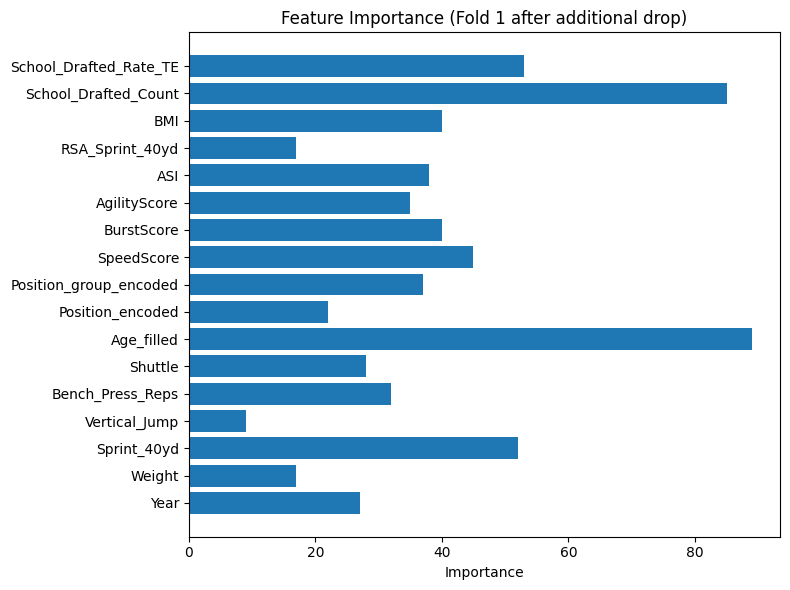

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[81]	valid_0's auc: 0.857403	valid_0's binary_logloss: 0.411912
✅ Fold 2 - Train AUC: 0.9343, Validation AUC: 0.8574
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data po

In [90]:
# 追加削除するカラム
drop_cols_additional = ["RSA_Vertical_Jump", "Broad_Jump", "Height","Agility_3cone"]

# すでに削除したカラムと合わせて削除
drop_cols_total = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
] + drop_cols_additional

# カラム削除
X_reduced2 = X.drop(columns=[col for col in drop_cols_total if col in X.columns])

# モデル定義（パラメータはそのまま）
model = LGBMClassifier(
    max_depth=8,
    num_leaves=10,
    min_child_samples=10,
    reg_alpha=0.0415,
    reg_lambda=0.2428,
    learning_rate=0.0726,
    n_estimators=1000,
    subsample=0.6898,
    colsample_bytree=0.7463,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after additional drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [91]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X_reduced2.columns で確定させる
feature_cols = X_reduced2.columns.tolist()

# test に存在しない列があれば埋める（安全）
missing_cols = set(feature_cols) - set(test.columns)
for col in missing_cols:
    test[col] = 0

# 列順を揃える
X_test = test[feature_cols]

# 予測
y_pred = model.predict_proba(X_test)[:, 1]


# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred
})

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "12_0628_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_12_0628.csv
